## 1. Load Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


## 2. Load Data

I am using Baseball Savant's pitchers dataset from their custom leaderboards tool. All data was accumulated between Opening Day and the morning of June 26, 2025. This data is compiled by Baseball Savant and is publicly available online for free. This dataset contains 119 observations with 10 features. Columns include five rate stats regarding pitch location and result. 

In [15]:
df = pd.read_csv("clustering25.csv")  

## 3. Feature Selection

I have selected five features that adequately contextualize a pitcher's performance over the course of the season. For all five, a greater positive percentage is better for the pitcher, and a lower positive percentage is worse for the pitcher. The percentages all relate to a pitcher's ability to induce weak contact and get results in/out of the zone. 

In [16]:
features = ['poorlyweak_percent', 'in_zone_percent', 
    'z_swing_percent', 'oz_swing_percent', 'whiff_percent']

## 4. Clean Data

In [17]:
df_clean = df.dropna(subset=features)

for col in df_clean.columns:
    if df_clean[col].dtype == 'object' and df_clean[col].str.endswith('%').any():
        df_clean[col] = df_clean[col].str.rstrip('%').astype(float) / 100

X = df_clean[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 5. Elbow and Silhouette Methods

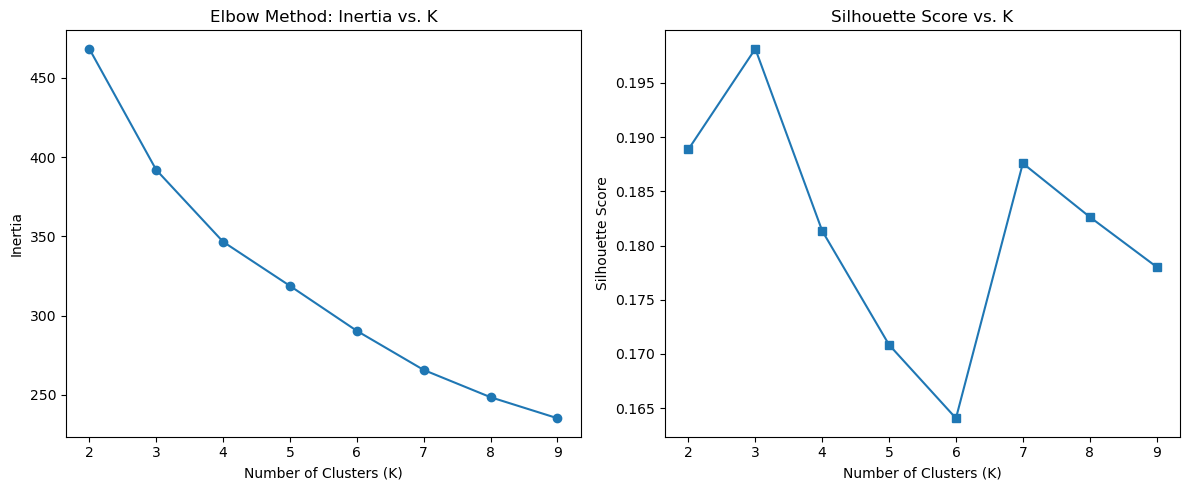

In [18]:
inertia = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(X_scaled)
    inertia.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(k_values, inertia, marker='o')
axs[0].set_title("Elbow Method: Inertia vs. K")
axs[0].set_xlabel("Number of Clusters, K")
axs[0].set_ylabel("Inertia")

axs[1].plot(k_values, silhouette_scores, marker='s')
axs[1].set_title("Silhouette Score vs. K")
axs[1].set_xlabel("Number of Clusters, K")
axs[1].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

The visualization on the left features my Elbow Method plot. This plot shows how the inertia consistently decreases as the number of clusters, K, increass. The curve looks like it might start to flatten or plateau around k=9.

The visualization on the right features my Silhouette Score plot. The trend shows a peak at K = 3, followed by a gradual decline until bottoming out at K = 6, then rising again. There is another peak at K = 7, though not as significant as the initial peak at K = 3. Since K = 3 had the largest Silhouette Score, I determine that 3 is the most appropriate selection for K as I move forward with my analysis.

## 6. K Means Cluster Visualization

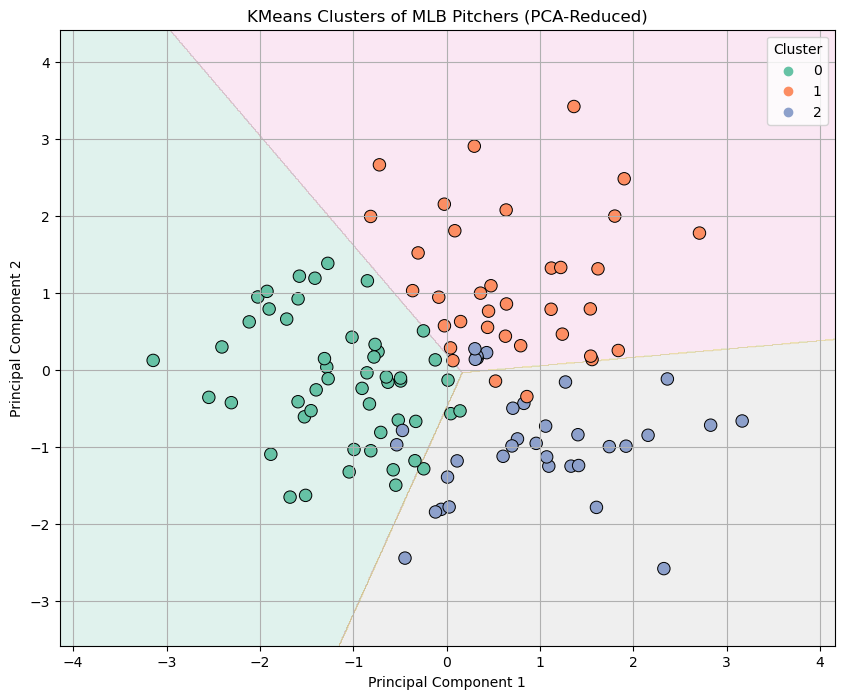

In [19]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)
df_clean['Cluster'] = labels

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_clean['PCA1'] = X_pca[:, 0]
df_clean['PCA2'] = X_pca[:, 1]

h = 0.01  
x_min, x_max = df_clean['PCA1'].min() - 1, df_clean['PCA1'].max() + 1
y_min, y_max = df_clean['PCA2'].min() - 1, df_clean['PCA2'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = kmeans.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, alpha=0.2, cmap='Set2')

sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=80, edgecolor='k')

plt.title("K-Means Cluster of MLB Pitchers")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

This scatterplot shows the four clusters (K) identified by my K-Means analysis. Each color represents a different cluster. For the most part, there is a firm contrast/threshold between the plotted points of the three different clusters, which suggests that K-Means was able to determine meaningful differences in pitcher types/results. 

The green (leftward) cluster reveals pitchers who get a lower whiff rate and don't induce much "free swinging." They are primarily in-zone pitchers, focusing on generating weak contact rather than missing bats. I would consider these pitchers to be conservative in their approach to opposing hitters.

The orange/pink (top right) cluster reveals pitchers who generate high whiff and out-of-zone swing rates. They likely have more deceptive or over-powering stuff, and they presumably prioritize strikeouts over weak contact. 

The blue (low right) region is likely pitchers who generate moderate swing tendencies, as they attack the zone but don't get many whiffs. They likely rely on called strikes and outs via contact. 